In [1]:
import pandas as pd
import os
os.chdir("/home/yangkai/codegen-detection")

In [2]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch
device = 1
checkpoint = "detector-large.pt"
data = torch.load(checkpoint, map_location='cpu')
model_name = 'roberta-large' if data['args']['large'] else 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model.load_state_dict(data['model_state_dict'])
model = model.to(device)
model.eval()

/home/yangkai/anaconda3/envs/openai_detector/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm

In [10]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
def serve(query):
    tokens = tokenizer.encode(query)
    all_tokens = len(tokens)
    tokens = tokens[:tokenizer.max_len - 2]
    used_tokens = len(tokens)
    tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
    mask = torch.ones_like(tokens)

    with torch.no_grad():
        logits = model(tokens.to(device), attention_mask=mask.to(device))[0]
        probs = logits.softmax(dim=-1)

    fake, real = probs.detach().cpu().flatten().numpy().tolist()

    return fake



hum_data = pd.read_pickle("dataset/mbpp_hum_test100.pkl")
gen_data = pd.read_pickle("dataset/mbpp_gen_test100_gpt4.pkl")

hum_data['label'] = 0
gen_data['label'] = 1
all_data = pd.concat([gen_data,hum_data])

score = []
for data in all_data['extracted_full_func'].tolist():
    fake_prob = serve(data)
    score.append(fake_prob)

label = all_data['label'].tolist()
roc_auc_score(label,score)

0.46440000000000003

## Supervised GraphCodeBert

In [6]:
from detection_models.bert import BertCLS
from transformers import AutoTokenizer
import torch
class Config:
    plm_name = "microsoft/graphcodebert-base"
    cls_drop = 0.2
    cls_dim = 768

load_pth = "gcb_supervised_apps_full.pt"
device = 0
cfg = Config()
model = BertCLS(cfg)
model.load_state_dict(torch.load(load_pth,map_location="cpu"))
model = model.to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(cfg.plm_name)

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from sklearn.metrics import roc_auc_score
max_len = 512
def serve(query):
    tokens = tokenizer.encode(query,add_special_tokens=False)
    all_tokens = len(tokens)
    tokens = tokens[:max_len - 2]
    used_tokens = len(tokens)
    tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
    mask = torch.ones_like(tokens)

    with torch.no_grad():
        x_hidden = model.plm(tokens.to(device),attention_mask=mask.to(device))[0]
        logits = model.cls_head(x_hidden[:, 0, :])

        probs = logits.softmax(dim=-1)

    real, fake = probs.detach().cpu().flatten().numpy().tolist()

    return fake

hum_data = pd.read_pickle("dataset/apps_hum_test.pkl")
gen_data = pd.read_pickle("dataset/apps_gen_test_starchat.pkl")

hum_data['label'] = 0
gen_data['label'] = 1
all_data = pd.concat([gen_data,hum_data])

score = []
for data in all_data['extracted_full_func'].tolist():
    fake_prob = serve(data)
    score.append(fake_prob)

label = all_data['label'].tolist()
roc_auc_score(label,score)

0.9256012818350481

## GPTZero

In [ ]:
import json
def load_json(f):
    return [json.loads(line.strip()) for line in open(f,'r').readlines()]
hum_resp = load_json("dataset/mbpp_hum_test_gptzero_resp.jsonl")
gen_resp = load_json("dataset/mbpp_gen_test_gptzero_resp.jsonl")

hum_data['gptzero_score'] = hum_resp
gen_data['gptzero_score'] = gen_resp

In [ ]:
def get_score(x):
    try:
        return x['documents'][0]['completely_generated_prob']
    except:
        print(x)
        return 0.5

all_data = pd.concat([gen_data,hum_data])
all_score = all_data['gptzero_score'].apply(get_score).tolist()
all_label = all_data['label'].tolist()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(all_label,all_score)

0.5686879478347363

In [ ]:
# APPS 51.89
# MBPP 56.87

# APPS in-domain 0.90 out-domain 51.62
# MBPP in-domain 0.99 out-domain 97.21

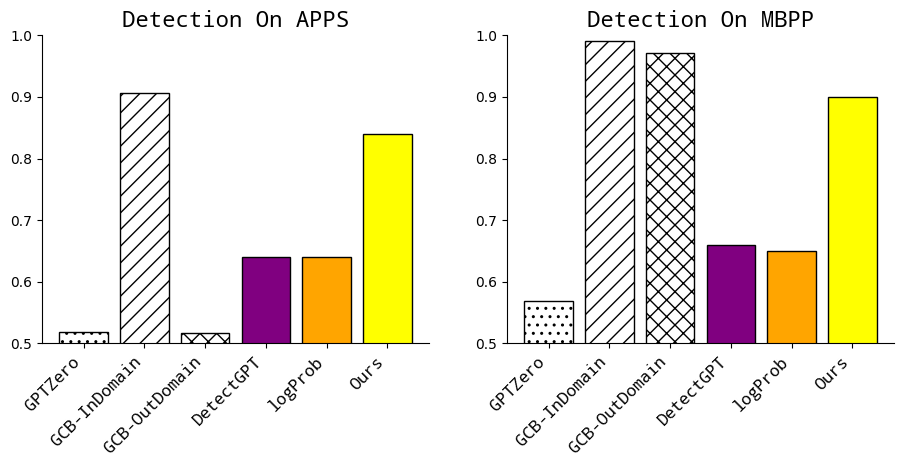

In [ ]:
import matplotlib.pyplot as plt

names = ['GPTZero','GCB-InDomain','GCB-OutDomain','DetectGPT','logProb','Ours']

apps_metric = [0.518,0.906,0.516,0.640,0.640,0.84]
mbpp_metric = [0.568,0.990,0.972,0.660,0.650,0.90]

fill_colors = ['white', 'white', 'white', 'purple', 'orange', 'yellow']
edge_colors = ['black'] * 6
hatches = ['..', '//', 'xx', '', '', '']
labels = ['Supervised','None','None','Zero-Shot','Zero-Shot','Zero-Shot']


# plt.rc('font', family='Times New Roman', size=10)
plt.figure(figsize=(11,4),dpi=100)
plt.subplot(1,2,1)
plt.bar(names,apps_metric, color=fill_colors, hatch=hatches, edgecolor=edge_colors)
ax=plt.gca()
ax.set_title("Detection On APPS",font='Noto Mono',size=16,fontweight='heavy')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylim([0.5, 1.0])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontname('Noto Mono')
    tick.set_fontsize(12)
# plt.grid(True)


plt.subplot(1,2,2)
plt.bar(names,mbpp_metric, color=fill_colors, hatch=hatches, edgecolor=edge_colors)
ax=plt.gca()
ax.set_title("Detection On MBPP",font='Noto Mono',size=16,fontweight='heavy')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylim([0.5, 1.0])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontname('Noto Mono')
    tick.set_fontsize(12)
# plt.grid(True)

plt.savefig("visuals/supervised_comp.pdf",format="pdf",bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.font_manager as fm

for font in fm.fontManager.ttflist:
    print(font.name)

STIXSizeOneSym
STIXSizeThreeSym
STIXSizeThreeSym
STIXNonUnicode
STIXSizeTwoSym
DejaVu Sans Mono
DejaVu Sans
STIXSizeOneSym
DejaVu Sans
cmb10
cmss10
cmr10
cmex10
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
STIXGeneral
STIXGeneral
cmsy10
DejaVu Serif
STIXSizeTwoSym
DejaVu Sans Mono
STIXSizeFiveSym
STIXNonUnicode
STIXGeneral
DejaVu Serif
DejaVu Serif
DejaVu Sans Mono
STIXSizeFourSym
DejaVu Serif
STIXGeneral
cmtt10
DejaVu Sans
STIXNonUnicode
DejaVu Serif Display
cmmi10
STIXSizeFourSym
STIXNonUnicode
Manjari
padmaa-Bold.1.1
Liberation Sans Narrow
Saab
Tlwg Typewriter
Nimbus Sans
Tlwg Mono
C059
Tlwg Typewriter
Nimbus Roman
Samyak Tamil
OpenSymbol
KacstNaskh
DejaVu Serif
Norasi
Sahadeva
Kinnari
Waree
Waree
Tlwg Typo
Liberation Sans
Meera
Sawasdee
Uroob
URW Gothic
Purisa
FreeSerif
C059
Kalimati
Nakula
Nimbus Sans
Garuda
Liberation Mono
Nimbus Mono PS
Loma
Lohit Odia
Ubuntu
Gargi
Liberation Serif
Phetsarath OT
Ubuntu
P052
Kinnari
Nimbus Sans Narrow
Karumbi
Garuda
Rasa
Kinnari
FreeMono
Stan